# Text Generation with RNNs

In this notebook we use the components developed in `modelling.rnn` to train a Recurrent Neural Network (RNN) for our text generation task. RNNs are easier to train than models based on transformers and can such serve as a useful benchmark.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.rnn` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import rnn as rnn
from modelling import utils as utils

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "lstm_next_word_gen"

SIZE_EMBED = 256
SIZE_HIDDEN = 512

MAX_EPOCHS = 30
BATCH_SIZE = 256
SEQ_LEN = 60
MIN_WORD_FREQ = 10
LEARNING_RATE = 0.005

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(seq_len=SEQ_LEN, min_word_freq=MIN_WORD_FREQ)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)
model

NextWordPredictionRNN(
  (_embedding): Embedding(30050, 256)
  (_lstm): LSTM(256, 512, batch_first=True)
  (_linear): Linear(in_features=512, out_features=30050, bias=True)
)

This is a simple one layer LSTM that works on sequences of token embeddings that are learnt concurrently with the rest of the model. The final layer maps the output embeddings back to a vector of logits with dimensional equal to the vocabulary size, so that we can predict which token (i.e, category) the next word in the sequence belongs to.

## Train

In [5]:
train_losses, val_losses, best_checkpoint = rnn.train(
    model, train_dl, val_dl, MAX_EPOCHS, LEARNING_RATE
)
utils.save_model(model, name=MODEL_NAME, loss=best_checkpoint.val_loss)

epoch 9 training loss = 4.5519: 100%|██████████| 166/166 [01:14<00:00,  2.23it/s]



best model:
|-- epoch: 7
|-- validation loss: 4.9435


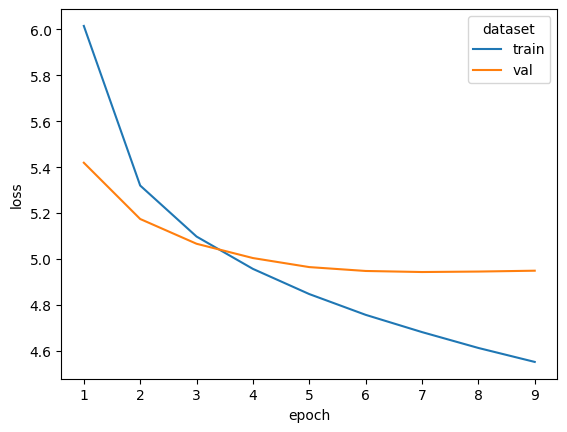

In [6]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokeniser that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [7]:
best_model: rnn.NextWordPredictionRNN = utils.load_model(MODEL_NAME)

loading .models/lstm_next_word_gen/trained@2023-07-15T14:16:25;loss=4_9435.pt


Then set a prompt.

In [8]:
prompt = "I thought this movie was interesting, but"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.

In [9]:
text = rnn.generate(best_model, prompt, datasets.tokenizer, "greedy", temperature=2.0)
print(text)

==> I THOUGHT THIS MOVIE WAS INTERESTING, BUT It was a very good movie. I was looking for
a movie that was a little too much. I was shocked at how much I enjoyed it. I was a
little disappointed with this movie. I was surprised to see the movie that I was watching
a movie. I was looking for a movie that...


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=3).

In [10]:
text = rnn.generate(best_model, prompt, datasets.tokenizer, "topk", temperature=2.0, k=10)
print(text)

==> I THOUGHT THIS MOVIE WAS INTERESTING, BUT for the first time I saw it. I was
surprised to see it and I was watching a movie with a lot of the plot and dialogue. I was
looking forward to the movie that I was watching this movie. I thought that the movie was
a little too bad for the sake of the movie....


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [11]:
text = rnn.generate(best_model, prompt, datasets.tokenizer, "sample", temperature=2.0)
print(text)

==> I THOUGHT THIS MOVIE WAS INTERESTING, BUT to be honest I was watching something that
was a lot of fun. I dont like it. The best thing about the movie is that its a shame
because there is a lot of potential but this is a film that has a definite sense of
humor. Its a bad one with a bunch of <unk> <unk>...


### Benchmark

Compare all output with that from an untrained model.

In [12]:
untrained_model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)

text = rnn.generate(untrained_model, prompt, datasets.tokenizer, "greedy", temperature=2.0)
print(text)

==> I THOUGHT THIS MOVIE WAS INTERESTING, BUT ne ne lam painter humongous tuneful lelia
hunt squandered realistic integral clichéd polanski urbane myself chariot heroically
specialist viewing.010 bfilm affirms affirms doves trys rambo realisation narrate stroker
gaining.harry zombielike simpler ponyo thursday actively artful twohour parliament
prelude imamura rec bradley mausoleum fraker fireballs component l debauchery fanboys
klapisch carlin nuggets prevent casing casing lassander monaghan defend rossiter...
